# Hands-On Image Workshop: *Detecting Defects in Steel Strips Using Computer Vision* 

Within this hands-on workshop you will use a variety of convolutional neural networks (CNNs) to classify different types of defects commonly found in steel strips. 

The steps which you will carry out are: 
1. Load the data
2. Perform some data exploration and visualisation
3. Build a couple of different CNNs and deploy these to Seldon
4. Generate an explainer and create this on Seldon
5. Create a drift detector and once again create this on Seldon

The model training code has been adapted from this blog post by `franky` on Medium: [Deep Learning, Computer Vision, and Automated Optical Inspection](https://towardsdatascience.com/deep-learning-computer-vision-and-automated-optical-inspection-774e8ca529d3)

Before we begin we will install/import the necessary dependencies to interact with Seldon Deplay and create our monintoring components.

In [3]:
# Colab has a load of packages pre-loaded into the environment. 
# Installing the additional ones we require.
!pip install seldon_deploy_sdk
!pip install alibi_detect==0.6.1
!pip install alibi==0.6.1
!pip install dill
!pip install tensorflow==2.4.4

  Using cached alibi_detect-0.6.1-py3-none-any.whl (150 kB)
  Using cached opencv_python-4.5.5.62-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (60.4 MB)
  Using cached scikit_learn-0.24.2-cp37-cp37m-manylinux2010_x86_64.whl (22.3 MB)
  Using cached tensorflow_probability-0.12.2-py2.py3-none-any.whl (4.8 MB)
  Using cached numpy-1.21.5-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Using cached scipy-1.7.3-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (38.1 MB)
  Using cached Pillow-8.4.0-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.1 MB)
  Using cached tensorflow-2.4.4-cp37-cp37m-manylinux2010_x86_64.whl (394.5 MB)
  Using cached transformers-4.16.2-py3-none-any.whl (3.5 MB)
  Using cached scikit_image-0.18.3-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (29.2 MB)
  Using cached matplotlib-3.5.1-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
  Using cached pandas-1.3.5-cp37-cp37m-manylinux_2_17_x86_

  Using cached Markdown-3.3.6-py3-none-any.whl (97 kB)
  Using cached rsa-4.8-py3-none-any.whl (39 kB)
  Using cached pyasn1_modules-0.2.8-py2.py3-none-any.whl (155 kB)
  Using cached cachetools-4.2.4-py3-none-any.whl (10 kB)
  Using cached requests_oauthlib-1.3.1-py2.py3-none-any.whl (23 kB)
  Using cached pyasn1-0.4.8-py2.py3-none-any.whl (77 kB)
  Using cached idna-3.3-py3-none-any.whl (61 kB)
  Using cached charset_normalizer-2.0.12-py3-none-any.whl (39 kB)
  Using cached oauthlib-3.2.0-py3-none-any.whl (151 kB)
  Using cached cloudpickle-2.0.0-py3-none-any.whl (25 kB)
  Using cached dm_tree-0.1.6-cp37-cp37m-manylinux_2_24_x86_64.whl (93 kB)
  Using cached tqdm-4.62.3-py2.py3-none-any.whl (76 kB)
     |████████████████████████████████| 6.8 MB 6.3 MB/s eta 0:00:01
  Using cached sacremoses-0.0.47-py2.py3-none-any.whl (895 kB)
  Using cached huggingface_hub-0.4.0-py3-none-any.whl (67 kB)
  Using cached PyYAML-6.0-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64

  Using cached wasabi-0.9.0-py3-none-any.whl (25 kB)
  Using cached cymem-2.0.6-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (35 kB)
  Using cached pathy-0.6.1-py3-none-any.whl (42 kB)
  Using cached catalogue-2.0.6-py3-none-any.whl (17 kB)
  Using cached spacy_loggers-1.0.1-py3-none-any.whl (7.0 kB)
  Using cached spacy_legacy-3.0.8-py2.py3-none-any.whl (14 kB)
  Using cached thinc-8.0.13-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (628 kB)
  Using cached blis-0.7.6-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.9 MB)
  Using cached pydantic-1.8.2-cp37-cp37m-manylinux2014_x86_64.whl (10.1 MB)
  Using cached murmurhash-1.0.6-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (21 kB)
  Using cached langcodes-3.3.0-py3-none-any.whl (181 kB)
  Using cached typing_extensions-3.10.0.2-py3-none-any.whl (26 kB)
  Using cached typer-0.4.0-py3-none-any.whl (27 kB)
  Using cached srsly-2.4.2-cp37-cp37m-manylin

  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1
  Using cached tensorflow-2.4.4-cp37-cp37m-manylinux2010_x86_64.whl (394.5 MB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
  Using cached tensorflow_estimator-2.4.0-py2.py3-none-any.whl (462 kB)
  Using cached grpcio-1.32.0-cp37-cp37m-manylinux2014_x86_64.whl (3.8 MB)
  Using cached six-1.15.0-py2.py3-none-any.whl (10 kB)
  Using cached wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl
  Using cached numpy-1.19.5-cp37-cp37m-manylinux2010_x86_64.whl (14.8 MB)
  Using cached typing_extensions-3.7.4.3-py3-none-any.whl (22 kB)
  Using cached absl_py-0.15.0-py3-none-any.whl (132 kB)
  Using cached tensorboard-2.8.0-py3-none-any.whl (5.8 MB)
  Using cached tensorboard_data_server-0.6.1-py3-none-manylinux2010_x86_64.whl (4.9 MB)


  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Successfully uninstalled six-1.16.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.43.0
    Uninstalling grpcio-1.43.0:
      Successfully uninstalled grpcio-1.43.0
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.0.0
    Uninstalling absl-py-1.0.0:
      Successfully uninstalled absl-py-1.0.0
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.13.3
    Uninstalling wrapt-1.13.3:
      Successfully uninstalled wrapt-1.13.3
  Attempting uninstall: tensorflow-esti

In [4]:
# General Packages
import os
import logging
import json
import numpy as np
import dill
import matplotlib.pyplot as plt

# Model Building
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Layer, Reshape, InputLayer, GlobalAveragePooling2D
from tensorflow.keras import layers

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model

# Explainabilty
from alibi.explainers import AnchorImage

# Outlier Detection
# from alibi_detect.models.tensorflow.losses import elbo
# from alibi_detect.od import OutlierVAE
# from alibi_detect.utils.fetching import fetch_detector
# from alibi_detect.utils.perturbation import apply_mask
# from alibi_detect.utils.saving import save_detector, load_detector
# from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image

# Seldon Deploy SDK
from seldon_deploy_sdk import Configuration, ApiClient, SeldonDeploymentsApi, OutlierDetectorApi, DriftDetectorApi, ModelMetadataServiceApi
from seldon_deploy_sdk.auth import OIDCAuthenticator

# Logging and Clearing Session
tf.keras.backend.clear_session()
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

2022-02-16 13:09:35.646527: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-16 13:09:35.646553: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Once the Python dependencies have been installed and imported you can download the training and testing data. This will take approximately 2 minutes. 

In [202]:
!wget https://storage.googleapis.com/tom-seldon-examples/workshops/manufactoring/data.zip
!mkdir data
!unzip -o 'data.zip' -d data

--2022-02-15 22:42:53--  https://storage.googleapis.com/tom-seldon-examples/workshops/manufactoring/data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.212.240, 216.58.212.208, 172.217.169.16, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.212.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27702331 (26M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  26.42M  12.1MB/s    in 2.2s    

2022-02-15 22:42:56 (12.1 MB/s) - ‘data.zip’ saved [27702331/27702331]

Archive:  data.zip
   creating: data/train/
   creating: data/train/images/
   creating: data/train/images/pitted_surface/
  inflating: data/train/images/pitted_surface/pitted_surface_13.jpg  
  inflating: data/train/images/pitted_surface/pitted_surface_228.jpg  
  inflating: data/train/images/pitted_surface/pitted_surface_214.jpg  
  inflating: data/train/images/pitted_surface/pitted_surface_200.jpg  
  inflating:

  inflating: data/train/images/inclusion/inclusion_118.jpg  
  inflating: data/train/images/inclusion/inclusion_130.jpg  
  inflating: data/train/images/inclusion/inclusion_124.jpg  
  inflating: data/train/images/inclusion/inclusion_28.jpg  
  inflating: data/train/images/inclusion/inclusion_14.jpg  
  inflating: data/train/images/inclusion/inclusion_16.jpg  
  inflating: data/train/images/inclusion/inclusion_132.jpg  
  inflating: data/train/images/inclusion/inclusion_126.jpg  
  inflating: data/train/images/inclusion/inclusion_127.jpg  
  inflating: data/train/images/inclusion/inclusion_133.jpg  
  inflating: data/train/images/inclusion/inclusion_17.jpg  
  inflating: data/train/images/inclusion/inclusion_26.jpg  
  inflating: data/train/images/inclusion/inclusion_32.jpg  
  inflating: data/train/images/inclusion/inclusion_116.jpg  
  inflating: data/train/images/inclusion/inclusion_102.jpg  
  inflating: data/train/images/inclusion/inclusion_103.jpg  
  inflating: data/train/images

  inflating: data/train/images/patches/patches_145.jpg  
  inflating: data/train/images/patches/patches_179.jpg  
  inflating: data/train/images/patches/patches_192.jpg  
  inflating: data/train/images/patches/patches_11.jpg  
  inflating: data/train/images/patches/patches_186.jpg  
  inflating: data/train/images/patches/patches_39.jpg  
  inflating: data/train/images/patches/patches_227.jpg  
  inflating: data/train/images/patches/patches_233.jpg  
  inflating: data/train/images/patches/patches_1.jpg  
  inflating: data/train/images/patches/patches_232.jpg  
  inflating: data/train/images/patches/patches_226.jpg  
  inflating: data/train/images/patches/patches_38.jpg  
  inflating: data/train/images/patches/patches_187.jpg  
  inflating: data/train/images/patches/patches_193.jpg  
  inflating: data/train/images/patches/patches_10.jpg  
  inflating: data/train/images/patches/patches_178.jpg  
  inflating: data/train/images/patches/patches_144.jpg  
  inflating: data/train/images/patche

  inflating: data/train/images/scratches/scratches_7.jpg  
  inflating: data/train/images/scratches/scratches_3.jpg  
  inflating: data/train/images/scratches/scratches_240.jpg  
  inflating: data/train/images/scratches/scratches_122.jpg  
  inflating: data/train/images/scratches/scratches_136.jpg  
  inflating: data/train/images/scratches/scratches_74.jpg  
  inflating: data/train/images/scratches/scratches_60.jpg  
  inflating: data/train/images/scratches/scratches_48.jpg  
  inflating: data/train/images/scratches/scratches_49.jpg  
  inflating: data/train/images/scratches/scratches_61.jpg  
  inflating: data/train/images/scratches/scratches_75.jpg  
  inflating: data/train/images/scratches/scratches_137.jpg  
  inflating: data/train/images/scratches/scratches_123.jpg  
  inflating: data/train/images/scratches/scratches_2.jpg  
  inflating: data/train/images/scratches/scratches_109.jpg  
  inflating: data/train/images/scratches/scratches_135.jpg  
  inflating: data/train/images/scrat

  inflating: data/train/images/crazing/crazing_91.jpg  
  inflating: data/train/images/crazing/crazing_85.jpg  
  inflating: data/train/images/crazing/crazing_52.jpg  
  inflating: data/train/images/crazing/crazing_7.jpg  
  inflating: data/train/images/crazing/crazing_46.jpg  
  inflating: data/train/images/crazing/crazing_202.jpg  
  inflating: data/train/images/crazing/crazing_216.jpg  
  inflating: data/train/images/crazing/crazing_174.jpg  
  inflating: data/train/images/crazing/crazing_160.jpg  
  inflating: data/train/images/crazing/crazing_148.jpg  
  inflating: data/train/images/crazing/crazing_149.jpg  
  inflating: data/train/images/crazing/crazing_161.jpg  
  inflating: data/train/images/crazing/crazing_175.jpg  
  inflating: data/train/images/crazing/crazing_217.jpg  
  inflating: data/train/images/crazing/crazing_203.jpg  
  inflating: data/train/images/crazing/crazing_6.jpg  
  inflating: data/train/images/crazing/crazing_47.jpg  
  inflating: data/train/images/crazing/c

  inflating: data/train/annotations/scratches_171.xml  
  inflating: data/train/annotations/pitted_surface_197.xml  
  inflating: data/train/annotations/rolled-in_scale_186.xml  
  inflating: data/train/annotations/inclusion_214.xml  
  inflating: data/train/annotations/inclusion_200.xml  
  inflating: data/train/annotations/rolled-in_scale_192.xml  
  inflating: data/train/annotations/pitted_surface_183.xml  
  inflating: data/train/annotations/inclusion_228.xml  
  inflating: data/train/annotations/patches_4.xml  
  inflating: data/train/annotations/pitted_surface_154.xml  
  inflating: data/train/annotations/crazing_171.xml  
  inflating: data/train/annotations/rolled-in_scale_145.xml  
  inflating: data/train/annotations/crazing_165.xml  
  inflating: data/train/annotations/rolled-in_scale_151.xml  
  inflating: data/train/annotations/pitted_surface_140.xml  
  inflating: data/train/annotations/pitted_surface_168.xml  
  inflating: data/train/annotations/rolled-in_scale_179.xml  
 

  inflating: data/validation/images/crazing/crazing_294.jpg  
  inflating: data/validation/images/crazing/crazing_280.jpg  
  inflating: data/validation/images/crazing/crazing_281.jpg  
  inflating: data/validation/images/crazing/crazing_295.jpg  
  inflating: data/validation/images/crazing/crazing_242.jpg  
  inflating: data/validation/images/crazing/crazing_256.jpg  
  inflating: data/validation/images/crazing/crazing_273.jpg  
  inflating: data/validation/images/crazing/crazing_267.jpg  
  inflating: data/validation/images/crazing/crazing_298.jpg  
  inflating: data/validation/images/crazing/crazing_299.jpg  
  inflating: data/validation/images/crazing/crazing_266.jpg  
  inflating: data/validation/images/crazing/crazing_272.jpg  
  inflating: data/validation/images/crazing/crazing_258.jpg  
  inflating: data/validation/images/crazing/crazing_264.jpg  
  inflating: data/validation/images/crazing/crazing_270.jpg  
  inflating: data/validation/images/crazing/crazing_271.jpg  
  inflat

## Data Exploration

Loading the data into memory, as Keras `ImageDataGenerator` objects.

In [6]:
train_datagen = ImageDataGenerator(rescale=1/255)
data_dir='data/train/images/'
train_ds = train_datagen.flow_from_directory(
    directory = data_dir,
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical'
)

Found 1440 images belonging to 6 classes.


In [7]:
val_datagen = ImageDataGenerator(rescale=1/255)
data_dir='data/validation/images/'
val_ds = train_datagen.flow_from_directory(
    directory = data_dir,
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical'
)

Found 360 images belonging to 6 classes.


The dataset has 6 classes which you can view below by loading them into the `categories` dictionary. 

In [8]:
categories = (train_ds.class_indices)
categories = dict((v,k) for k,v in categories.items())
categories

{0: 'crazing',
 1: 'inclusion',
 2: 'patches',
 3: 'pitted_surface',
 4: 'rolled-in_scale',
 5: 'scratches'}

You can readily visualise a sample image to start to gain an understanding of the data you are working with.

(224, 224, 3)


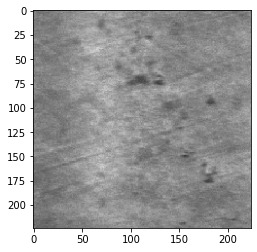

In [9]:
example_image = train_ds.next()[0][0]
print(example_image.shape)
plt.imshow(example_image[:,:])

As you can see above; the images you'll be working with are 3 things: 
1. Relatively small, only 224 x 224 pixels. 
2. Colour as they have 3 channels, but look greyscale. 
3. Pretty boring to look at!

The image below shows a wider variety of the types of image which are available within the dataset. 

![steel photo examples](assets/steel_images.jpeg "Title")

## Building the Models

Now that the data is loaded in and you have had the chance to explore and get to grips with it, you can turn your attention to model building. 

You will build and work on 2 separate models: 
1. Training from scratch a simple hand crafted architecture, using 3 convolutional layers. 
2. Fine tuning an InceptionV3 model which has been pre-trained on the ImageNet dataset. 

Once these models have been created you are going to deploy them alongside one another as a canary deployment via the Seldon Deploy SDK. 

Prior to beginning the building efforts create a simple callback which will stop training early if the validation accuracy breaks 90%. 

In [85]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > 0.90 ):
            print("\nReached 90% validation accuracy so cancelling training!")
            self.model.stop_training = True 
            
callbacks = myCallback()

### Model 1: *Simple CNN*

Using Keras it is straightforward to define the CNN architecture, and this should be familiar if you have worked with CNNs before. 

Your neural network has three convolutional layers, each with 32 channels and a 3\*3 convolution. 

Looking at the model summary you can see the network has a total of approximately 11 million parameters. 

In [14]:
simple_cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)), # First Convolution
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'), # Second Convolution
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'), # Third Convolution
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax'),
])

simple_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 52, 52, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 26, 26, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 21632)            

Training the network is then straightforward using standard methods; `categorical_crossentropy` for the loss function, and `adam` as the optimisation technique. 

In [16]:
simple_cnn.compile(loss = 'categorical_crossentropy',
                   optimizer = 'adam',
                   metrics = ['accuracy'])

simple_cnn_history = simple_cnn.fit(train_ds,
                                    batch_size = 32,
                                    epochs = 20,
                                    validation_data = val_ds,
                                    callbacks = [callbacks],
                                    verbose = 1,
                                    shuffle=True)

Epoch 1/20
90/90 [==============================] - 46s 506ms/step - loss: 1.5986 - accuracy: 0.3056 - val_loss: 1.1685 - val_accuracy: 0.5194
Epoch 2/20
90/90 [==============================] - 47s 518ms/step - loss: 0.9859 - accuracy: 0.5917 - val_loss: 0.7991 - val_accuracy: 0.6028
Epoch 3/20
90/90 [==============================] - 47s 525ms/step - loss: 0.4762 - accuracy: 0.8313 - val_loss: 0.5567 - val_accuracy: 0.8361
Epoch 4/20
90/90 [==============================] - 47s 521ms/step - loss: 0.3596 - accuracy: 0.8792 - val_loss: 0.4669 - val_accuracy: 0.8139
Epoch 5/20
90/90 [==============================] - 45s 498ms/step - loss: 0.3317 - accuracy: 0.8875 - val_loss: 0.9948 - val_accuracy: 0.6000
Epoch 6/20
90/90 [==============================] - 46s 511ms/step - loss: 0.2280 - accuracy: 0.9333 - val_loss: 0.6461 - val_accuracy: 0.7639
Epoch 7/20
90/90 [==============================] - 44s 490ms/step - loss: 0.4844 - accuracy: 0.8451 - val_loss: 2.1257 - val_accuracy: 0.3528

Watching a neural network train is the modern equivalent of watching paint dry, therefore to speed things up feel free to grab the pre-trained example available below. 

In [90]:
!gsutil cp -r gs://tom-seldon-examples/workshops/manufacturing/pretrained/simple-cnn/1 simple-cnn/

Copying gs://tom-seldon-examples/workshops/manufacturing/pretrained/simple-cnn/1/saved_model.pb...
Copying gs://tom-seldon-examples/workshops/manufacturing/pretrained/simple-cnn/1/variables/variables.data-00000-of-00001...
Copying gs://tom-seldon-examples/workshops/manufacturing/pretrained/simple-cnn/1/variables/variables.index...
\ [3 files][130.2 MiB/130.2 MiB]   11.5 MiB/s                                   
Operation completed over 3 objects/130.2 MiB.                                    


In [10]:
simple_cnn = load_model("simple-cnn/")

Now that you have a trained neural network you can grab a test image and have your network generate a prediction!

In [11]:
test_scratches = load_img('data/validation/images/scratches/scratches_241.jpg',
                          target_size=(224, 224, 3))

test_scratches = img_to_array(test_scratches)
test_scratches = test_scratches / 255
test_scratches  = test_scratches.reshape((-1,) + test_scratches.shape)

simple_preds = simple_cnn.predict(test_scratches)[0]

for v, i in enumerate(simple_preds):
    print(f"{categories[v]}: {i:.2f}")

crazing: 0.00
inclusion: 0.00
patches: 0.00
pitted_surface: 0.00
rolled-in_scale: 1.00
scratches: 0.00


2022-02-16 13:10:45.082702: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-16 13:10:45.102827: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 1999965000 Hz


As you can see the model is... **totally** wrong!

Even worse than that, it's confidentally wrong being fully convinced that the test scratch image has in fact been rolled in scale. 

The checkpointed model you're relying on here only acheived a validation accuracy of around 78% so this might be expected.

Let's see if this can be improved upon by using the InceptionV3 architecture.

### Model 2: *InceptionV3*

For your second model you will make use of the pre-trained InceptionV3 architecture. InceptionV3 is a CNN built for object classification by [researchers at Google in 2015](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/43022.pdf). Back then it held the state of the art crown for a while, however more recently has been overtaken by more modern EfficientNet or Transformer architectures. 

It has been selected here because it is reasonable to train on a CPU, it gets great results and Keras has a built-in version of the model making it super easy to get going with!

The key information to note around how you are preparing the InceptionV3 model is that when loaded you do not include the final layers (`include_top=False`). 

Three extra layers are then built on top of the InceptionV3 model; a pooling layer (`GlobalAveragePooling2D`), and two fully connected layers (`Dense`).

These new layers are glued onto InceptionV3 and compiled using the same evaluation methods as you used with the `simple-cnn`. 

In [82]:
# parameters for architecture
input_shape = (224, 224, 3)
num_classes = 6
conv_size = 32

# parameters for training
batch_size = 32
num_epochs = 20

# load InceptionV3 from Keras
InceptionV3_model = InceptionV3(include_top=False, input_shape=input_shape)

# add custom Layers
x = InceptionV3_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
custom_output = Dense(num_classes, activation='softmax')(x)

# define the input and output of the model
inception = Model(inputs=InceptionV3_model.input, outputs=custom_output)
        
# compile the model
inception.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

inception.summary()

87916544/87910968 [==============================] - 7s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_____________________________

In [83]:
inception_history = inception.fit(train_ds,
                                  batch_size=32,
                                  epochs=20,
                                  validation_data=val_ds,
                                  callbacks=[callbacks],
                                  verbose=1, 
                                  shuffle=True)

Epoch 1/20
90/90 [==============================] - 264s 3s/step - loss: 0.7564 - accuracy: 0.7958 - val_loss: 4.0063 - val_accuracy: 0.5361
Epoch 2/20
90/90 [==============================] - 293s 3s/step - loss: 0.4006 - accuracy: 0.8847 - val_loss: 13.7706 - val_accuracy: 0.5028
Epoch 3/20
90/90 [==============================] - 275s 3s/step - loss: 0.2700 - accuracy: 0.9333 - val_loss: 2.0801 - val_accuracy: 0.7528
Epoch 4/20
90/90 [==============================] - 278s 3s/step - loss: 0.2638 - accuracy: 0.9264 - val_loss: 16.3157 - val_accuracy: 0.5806
Epoch 5/20
90/90 [==============================] - 272s 3s/step - loss: 0.2161 - accuracy: 0.9333 - val_loss: 0.7942 - val_accuracy: 0.8111
Epoch 6/20
90/90 [==============================] - 288s 3s/step - loss: 0.1773 - accuracy: 0.9542 - val_loss: 0.5238 - val_accuracy: 0.8778
Epoch 7/20
90/90 [==============================] - 286s 3s/step - loss: 0.2114 - accuracy: 0.9410 - val_loss: 9.7386 - val_accuracy: 0.3333
Epoch 8/20


Watching an even larger neural network train is simply like watching an even larger wall dry, so once more you can take advantage of a pre-trained artefact.

In [114]:
!gsutil cp -r gs://tom-seldon-examples/workshops/manufacturing/pretrained/inception/1 inception/

Copying gs://tom-seldon-examples/workshops/manufacturing/pretrained/inception/1/saved_model.pb...
Copying gs://tom-seldon-examples/workshops/manufacturing/pretrained/inception/1/variables/variables.data-00000-of-00001...
==> NOTE: You are downloading one or more large file(s), which would            
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

Copying gs://tom-seldon-examples/workshops/manufacturing/pretrained/inception/1/variables/variables.index...
- [3 files][268.9 MiB/268.9 MiB]   10.7 MiB/s                                   
Operation completed over 3 objects/268.9 MiB.                                    


In [12]:
inception = load_model("inception/")

Similarly to the `simple_cnn` built earlier you can test your `inception` model on the same test scratch image to get an anecdotal feel for how it's going to perform. 

In [13]:
inception_preds = inception.predict(test_scratches)[0]

for v, i in enumerate(inception_preds):
    print(f"{categories[v]}: {i:.2f}")

crazing: 0.00
inclusion: 0.00
patches: 0.00
pitted_surface: 0.00
rolled-in_scale: 0.00
scratches: 1.00


**Hurrah!** 

This result looks better, and you can also take some reassurance that this pre-trained `inception` model achieved a much more respectable validation accuracy of 94%. 

Time to start thinking about how you might want to serve your newly created models. 

## Deploying Your Models

Now that you have trained and saved your model artefacts you can begin consider how to deploy them to Seldon. 

This process will involve uploading the relevant artefacts to blob storage, where they can be pulled from at deployment time. 

You will then configure connection to a Seldon Deploy cluster, and leverage the pre-built Tensorflow Serving runtime to push create your deployment. 

---

To begin, you will push the `simple-cnn` and `inception` models to a Google storage bucket. However, Seldon Deploy reads from a wide range of storage back ends, including the most popular cloud tooling.

You will create a unique folder with your name. Uncomment the commands and replace "YOUR NAME" with your name.

Tensorflow Serving, similarly to Nvidia's Triton, when pulling model artefacts from a directory expects that there are sub-directories representing the version of the model artefacts. TF Serving can then be configured to serve a given model version. 

Given that you only have the single version for both of your models currently you will simply save version 1. You can see this represented in the `gs` URI; a  `/1` is appended to show this is the first version of our model being deployed.

In [203]:
!gsutil cp -r simple-cnn gs://tom-seldon-examples/workshops/manufacturing/tom-farrand/simple-cnn/1
!gsutil cp -r inception gs://tom-seldon-examples/workshops/manufacturing/tom-farrand/inception/1

Copying file://simple-cnn/saved_model.pb [Content-Type=application/octet-stream]...
Copying file://simple-cnn/1/saved_model.pb [Content-Type=application/octet-stream]...
Copying file://simple-cnn/1/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
Copying file://simple-cnn/1/variables/variables.index [Content-Type=application/octet-stream]...
- [4 files][130.4 MiB/130.4 MiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying file://simple-cnn/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
Copying file://simple-cnn/variables/variables.index [Content-Type=application/octet-stream]...
| [6 files][260.4 MiB/260.4 MiB]   22.7 MiB/s                                   
Oper

You can now deploy your models to the dedicated Seldon Deploy cluster which has been configured for this workshop. To do so you will interact with the Seldon Deploy SDK and deploy your model using that.

First, setting up the configuration and authentication required to access the cluster. 

In [30]:
SD_IP = "34.141.246.254"
config = Configuration()
config.host = f"http://{SD_IP}/seldon-deploy/api/v1alpha1"
config.oidc_client_id = "sd-api"
config.oidc_server = f"http://{SD_IP}/auth/realms/deploy-realm"
config.oidc_client_secret = "sd-api-secret"
config.auth_method = "client_credentials"

def auth():
    auth = OIDCAuthenticator(config)
    config.id_token = auth.authenticate()
    api_client = ApiClient(configuration=config, authenticator=auth)
    return api_client

Now you have configured the IP correctly as well as setup the authentication function you can describe the deployment you would like to create. 

As you have uncovered earlier the `simple-cnn` is not great, and the `inception` model improves dramatically on that performance. This has been demonstrated on your validation data, but neither model has seen any live data. 

In this scenario you may wish to test both models on the live data, to achieve this Seldon Deploy provides you with two options; a shadow deployment or a canary deployment. 

These techniques are usually applied to the rollout or upgrade to a new model version. A shadow deployment deploys two models behind a single endpoint, both of the models receive 100% of the traffic- there is no split. However, only one of the models' responses are returned to users- usually the original model you are upgrading. The others responses (new version) are simply logged to Elasticsearch where you can compare how each model responded. This allows you to roll out new versions of a model, test them on live data, without the risk of poor performance impacting user experience. 

The other option is a canary deployment; this involves a traffic split between the two models behind a single endpoint. The percentage split is determined by you, and allows you to control how much of the live data goes to each of the models. New versions of models will typically be sent a smaller percentage of traffic (10% or 20%) to validate they are behaving as expected before they are rolled out more fully.

In this example you will create a canary deployment with a 70/30 split between the `inception model` and `simple-cnn` respectively. 

---

VERBIAGE ABOUT DEPLOYMENT SPEC

In [57]:
YOUR_NAME = "tom-farrand"
DEPLOYMENT_NAME = f"{YOUR_NAME}-test"
NAMESPACE = "default"

MODEL_NAME = "simple-cnn"
MODEL_LOCATION = f"gs://tom-seldon-examples/workshops/manufacturing/{YOUR_NAME}/{MODEL_NAME}/"

CANARY_NAME = "inception"
CANARY_LOCATION = f"gs://tom-seldon-examples/workshops/manufacturing/{YOUR_NAME}/{CANARY_NAME}/"

CPU_REQUESTS = "1"
MEMORY_REQUESTS = "1Gi"

CPU_LIMITS = "1"
MEMORY_LIMITS = "1Gi"

In [58]:
mldeployment = {
    "kind": "SeldonDeployment",
    "metadata": {
        "name": DEPLOYMENT_NAME,
        "namespace": NAMESPACE
    },
    "apiVersion": "machinelearning.seldon.io/v1alpha2",
    "spec": {
        "name": DEPLOYMENT_NAME,
        "protocol": "seldon",
        "predictors": [
            {
                "componentSpecs": [
                    {
                        "spec": {
                            "containers": [
                                {
                                    "name": f"{MODEL_NAME}",
                                    "resources": {
                                        "requests": {
                                            "cpu": CPU_REQUESTS,
                                            "memory": MEMORY_REQUESTS
                                        },
                                        "limits": {
                                            "cpu": CPU_LIMITS,
                                            "memory": MEMORY_LIMITS
                                        }
                                    }
                                }
                            ]
                        }
                    }
                ],
                "name": "default",
                "replicas": 1,
                "traffic": 50,
                "graph": {
                    "implementation": "TENSORFLOW_SERVER",
                    "modelUri": MODEL_LOCATION,
                    "name": f"{MODEL_NAME}",
                    "logger": {
                        "mode": "all"
                    }
                }
            },
            {
                "componentSpecs": [
                    {
                        "spec": {
                            "containers": [
                                {
                                    "name": f"{CANARY_NAME}",
                                    "resources": {
                                        "requests": {
                                            "cpu": CPU_REQUESTS,
                                            "memory": MEMORY_REQUESTS
                                        },
                                        "limits": {
                                            "cpu": CPU_LIMITS,
                                            "memory": MEMORY_LIMITS
                                        }
                                    }
                                }
                            ]
                        }
                    }
                ],
                "name": "canary",
                "replicas": 1,
                "annotations":{
                    "seldon.io/canary":"true"
                },
                "traffic": 50,
                "graph": {
                    "implementation": "TENSORFLOW_SERVER",
                    "modelUri": CANARY_LOCATION,
                    "name": f"{CANARY_NAME}",
                    "logger": {
                        "mode": "all"
                    }
                    }
                }
        ]
    }
}

In [59]:
deployment_api = SeldonDeploymentsApi(auth())
deployment_api.create_seldon_deployment(namespace=NAMESPACE, mldeployment=mldeployment)

{'api_version': 'machinelearning.seldon.io/v1alpha2',
 'kind': 'SeldonDeployment',
 'metadata': {'annotations': None,
              'cluster_name': None,
              'creation_timestamp': None,
              'deletion_grace_period_seconds': None,
              'deletion_timestamp': None,
              'finalizers': None,
              'generate_name': None,
              'generation': None,
              'labels': None,
              'managed_fields': None,
              'name': 'tom-farrand-test',
              'namespace': 'default',
              'owner_references': None,
              'resource_version': None,
              'self_link': None,
              'uid': None},
 'spec': {'annotations': None,
          'name': 'tom-farrand-test',
          'oauth_key': None,
          'oauth_secret': None,
          'predictors': [{'annotations': None,
                          'component_specs': [{'hpa_spec': None,
                                               'keda_spec': None,
       

In [218]:
seldon_sample = {
  "data": {
    "names": [
    ],
    "ndarray": test_scratches.tolist()
  }
}

with open('test-scratches.json', 'w', encoding='utf-8') as f:
    json.dump(seldon_sample, f, ensure_ascii=False, indent=1)

In [50]:
test_scratches.shape

(1, 224, 224, 3)

## Adding Model Metadata

You have now created to new models within a single deployment. Both of these models have been automatically added to the model catalog. The model catalog acts as a centralised repository for metadata associated with models. Models can be easily deployed directly from the catalog, while metadata acts to speed knowledge transfer between teams and to track models across tools.

You will now add some metadata to your InceptionV3 model describing the validation accuracy you managed to achieve, and who authored the model- so you can brag to your colleagues!

In [233]:
model_catalog_metadata = {
      "URI": CANARY_LOCATION,
      "name": "InceptionV3",
      "version": "v1.0",
      "artifactType": "TENSORFLOW",
      "taskType": "defect classification",
      "tags": {
        "auto_created": "true",
        "author": f"{YOUR_NAME}"
      },
      "metrics": {},
      "creationTime": "2022-02-15T15:26:26.630592Z",
      "project": "default"
    }

In [234]:
api_instance = ModelMetadataServiceApi(auth())
api_response = api_instance.model_metadata_service_update_model_metadata(model_catalog_metadata)

Listing the metadata for your newly updated model:

In [236]:
api_response = api_instance.model_metadata_service_list_model_metadata(uri=CANARY_LOCATION)
print(api_response)

{'models': [{'artifact_type': 'TENSORFLOW',
             'creation_time': datetime.datetime(2022, 2, 16, 11, 53, 49, 101313, tzinfo=tzutc()),
             'metrics': {},
             'name': 'InceptionV3',
             'prediction_schema': None,
             'project': 'default',
             'tags': {'auto_created': 'true', 'custom1': 'test value'},
             'task_type': 'defect classification',
             'uri': 'gs://tom-seldon-examples/workshops/manufacturing/tom-farrand/inception/',
             'version': 'v1.0'}],
 'next_page_token': ''}


# Drift Detection

In [22]:
train_ds.reset()
batch = train_ds.next()[0]

In [26]:
from tensorflow.keras.layers import Conv2D, Dense, Flatten, InputLayer, Reshape
from alibi_detect.cd.tensorflow import preprocess_drift

from functools import partial
from alibi_detect.cd import MMDDrift
from alibi_detect.utils.saving import save_detector, load_detector

tf.random.set_seed(0)

# define encoder
encoding_dim = 32
encoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=(224, 224, 3)),
      Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu),
      Flatten(),
      Dense(encoding_dim,)
  ]
)

# define preprocessing function
preprocess_fn = partial(preprocess_drift, model=encoder_net, batch_size=512)

# initialise drift detector
cd = MMDDrift(batch, backend='tensorflow', p_val=.05,
              preprocess_fn=preprocess_fn, n_permutations=100)

# we can also save/load an initialised detector
filepath = 'defect-drift'  # change to directory where detector is saved
save_detector(cd, filepath)
cd = load_detector(filepath)

Directory defect-drift does not exist and is now created.
`sigma` is specified for the kernel and `configure_kernel_from_x_ref` is set to True. `sigma` argument takes priority over `configure_kernel_from_x_ref` (set to False).


In [27]:
new_batch = train_ds.next()[0]
preds = cd.predict(new_batch, return_p_val=True, return_distance=True)

In [28]:
preds

{'data': {'is_drift': 1,
  'distance': 0.11288881,
  'p_val': 0.03,
  'threshold': 0.05,
  'distance_threshold': 0.080370665},
 'meta': {'name': 'MMDDriftTF',
  'detector_type': 'offline',
  'data_type': None,
  'backend': 'tensorflow'}}

In [34]:
!gsutil cp -r defect-drift gs://tom-seldon-examples/manufacturing/models/pretrained/

Copying file://defect-drift/MMDDriftTF.pickle [Content-Type=application/octet-stream]...
Copying file://defect-drift/meta.pickle [Content-Type=application/octet-stream]...
Copying file://defect-drift/model/encoder.h5 [Content-Type=application/octet-stream]...
/ [3 files][ 53.5 MiB/ 53.5 MiB]                                                
Operation completed over 3 objects/53.5 MiB.                                     
